In [5]:
import os, pickle, re, sklearn, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from datetime import datetime
from nltk.stem.porter import PorterStemmer

In [6]:
def load_data(file):
    return pd.read_csv(file)

In [7]:
def clean_doc(doc):
    stopwords = {}
    stopwords = set(stop_words.ENGLISH_STOP_WORDS)
    doc = doc.lower()
    doc = re.sub(r"[0-9]+", "", doc)
    tokens = doc.split()
    tokens = [w for w in tokens if not w in stopwords]
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    tokens = [word for word in tokens if len(word) > 1]
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]    
    return ' '.join(tokens)

In [34]:
def create_voc(reviews):
    vocabularyDict = {}
    vocabularyList = []
    for i in range(len(reviews)):
        r = reviews[i]
        tokens = set(r.split())
        for token in tokens:
            if token not in vocabularyDict.keys():
                vocabularyDict[token] = 1
            else:
                vocabularyDict[token] = vocabularyDict[token] + 1    
    for key in vocabularyDict.keys():
        if vocabularyDict[key] >= 30:
            vocabularyList.append(key)
    return vocabularyList

In [9]:
def createFeatureVectors(reviews, vocabularyList):
    featureXVectors = []
    for i in range(len(reviews)):
        r = reviews[i]
        tokens = set(r.split())
        fVector=[]
        for token in vocabularyList:
            if token in tokens:
                fVector.append(1)
            else:
                fVector.append(0)
        featureXVectors.append(fVector)

    featureVectors = np.asarray(featureXVectors)
    return featureVectors;

In [10]:
def review_cleaning(data):
    review = []
    for row in data:
        review.append(clean_doc(row))
    return review

In [11]:
def preprocessing(data, reviews):
    dataX = []
    dataY = []  
    j=-1
    for i, row in data.iterrows():
        j=j+1
        dataY.append(row['label'])
        l = np.sum(reviews[j])
        # elem = [row['user_id'],row['prod_id'],int(row['rating']),date.day,date.month,date.year] + [l] + reviews[index].tolist()
        elem = [row['user_id'],row['prod_id'],int(row['rating'])] + [l]
        #elem = [row['user_id'],row['prod_id'],int(row['rating'])] + [l] + reviews[index].tolist()
        dataX.append(elem)
    return dataX, dataY

In [26]:
# load data
data = load_data('train.csv')

In [27]:
print(data.shape)

(250874, 7)


In [29]:
# Separate majority and minority classes

from sklearn.utils import resample
df_majority = data[data.label==0]
df_minority = data[data.label==1]
print(len(df_minority))
print(len(df_majority))
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

data = df_downsampled
# Display new class counts
df_downsampled.label.value_counts()

25819
25819


1    25819
0    25819
Name: label, dtype: int64

In [30]:
data.shape

(51638, 7)

In [31]:
# clean review
review = review_cleaning(data['review'])
print(review[0])

cute dessert place overhyp black sesam creme brule bf scoop jasmin ice cream green tea ice cream friend dessert scoop mix berri ice cream sort layer cracker fill berri thingymajiggi idk call look good dessert bf good wasnt wowfactor read yelp especi price paid


In [32]:
len(review)

51638

In [35]:
# create vocabulary List
vocabularyList = create_voc(review);
print("Size of Vocabulary list = ",len(vocabularyList))

Size of Vocabulary list =  4481


In [36]:
# create review feature
rf = createFeatureVectors(review, vocabularyList)

In [37]:
data.shape

(51638, 7)

In [38]:
dataX, dataY = preprocessing(data, rf)

In [39]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(dataX,dataY,test_size=0.3,random_state=109)

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)
print(X_train[0])

[-0.96571528  0.13015184  0.5        -0.81318681]


In [41]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [42]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6720242705912729


In [43]:
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.6609345351043643
Recall: 0.7149454778704297


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4838 2859]
 [2222 5573]]
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      7697
           1       0.66      0.71      0.69      7795

    accuracy                           0.67     15492
   macro avg       0.67      0.67      0.67     15492
weighted avg       0.67      0.67      0.67     15492



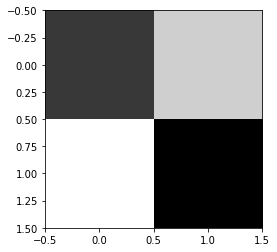

In [45]:
import matplotlib.pyplot as plt
conf = sklearn.metrics.confusion_matrix(y_test, y_pred)
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()

In [ ]:
## testing on dev file
